In [1]:
%matplotlib inline
from read_db import read_db
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.learning_curve import learning_curve
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score

from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

/home/yanxin/anaconda2/envs/insight/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [2]:
weather, running, full, stat= read_db()

In [3]:
datasets=stat[['count','dayofweek','mean_tempf','max_tempf','precipitationIn',
	'mean_dew_pointf','mean_hum','mean_wind_speed','wind_dir_degrees',
	'mean_visibility_miles','cloudcover','mean_sea_level_pressure_in','events']]

datasets['events']=datasets['events'].fillna(value = 'Clear')
datasets['id'] = datasets['events'].astype('category').cat.codes
datasets['precipitationIn']=datasets['precipitationIn'].replace('T',0)
datasets['precipitationIn']=datasets['precipitationIn'].astype(float)
datasets=datasets.dropna().drop('events',1)
datasets=datasets.astype(int)

In [4]:
X=datasets[['dayofweek','mean_tempf','max_tempf','precipitationIn',
	'mean_dew_pointf','mean_hum','mean_wind_speed','wind_dir_degrees',
	'mean_visibility_miles','cloudcover','mean_sea_level_pressure_in']]

y = datasets['count']

<Container object of 11 artists>

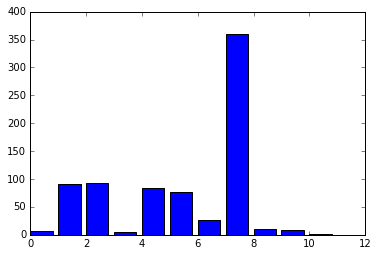

In [5]:
unique_values = [len(np.unique(X.values[:,i])) for i in range(X.values.shape[1])]
plt.bar(range(X.values.shape[1]),unique_values)

In [6]:
#np.unique(X.values[:,9])

In [7]:
enc = OneHotEncoder(categorical_features=np.array(unique_values)<11)
X_nocat1 = enc.fit_transform(np.array(X.values))
X_nocat = X_nocat1.toarray()

In [8]:
#np.unique(y.unique(),return_counts = True)

In [9]:
yy=y.values
y_norm_nocat=yy
for i in range(len(yy)):
    if yy[i]> 6:
        y_norm_nocat[i] = 1
    else:
        y_norm_nocat[i] =0
y_norm_nocat

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
X_norm_nocat = (X_nocat-np.mean(X_nocat, axis=0))/np.std(X_nocat, axis=0)
X_train,X_test,y_train,y_test=train_test_split(X_norm_nocat,y_norm_nocat,test_size = 0.25)

In [11]:
len(y_test)

1639

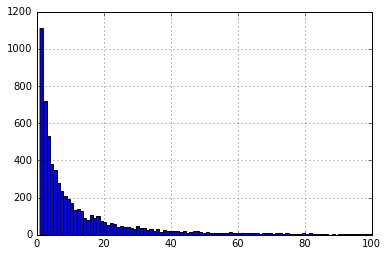

In [12]:
stat[stat['count']<=100]['count'].hist(bins = 100)

In [13]:
stat[stat['count']<=6]['count'].count()

3369

In [14]:
stat['count'].count()

6557

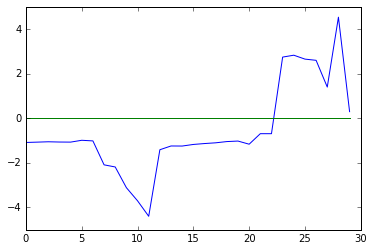

In [15]:
plt.plot(np.log(np.std(X_nocat, axis=0)))
plt.plot(np.log(np.std(X_norm_nocat, axis=0)))

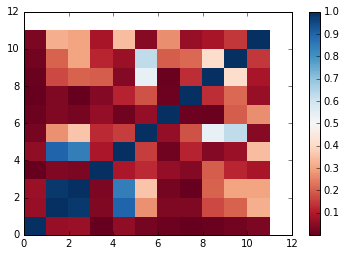

In [16]:
plt.pcolor(np.abs(np.corrcoef(X.T)), cmap='RdBu')

plt.colorbar()

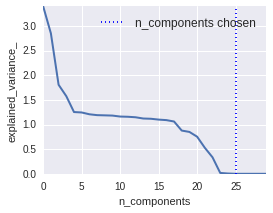

In [55]:
model = LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', model)])

pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [1,5,10,15,20,25,30]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

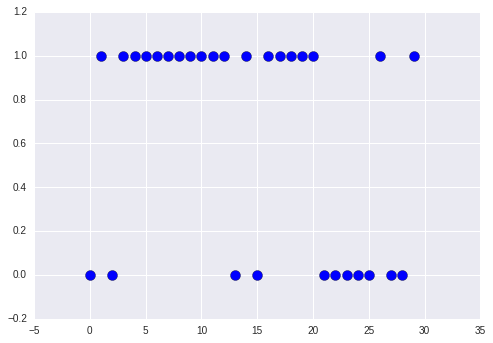

In [13]:
from scipy.stats import mannwhitneyu

F = X_norm_nocat.shape[1]

probabilities = [mannwhitneyu(X_norm_nocat[y==0, i], X_norm_nocat[y==1, i])[1] for i in range(F)]

plt.scatter(range(F), probabilities, 100)

In [56]:
cvmodel.best_estimator_

LogisticRegression(C=0.12328467394420665, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

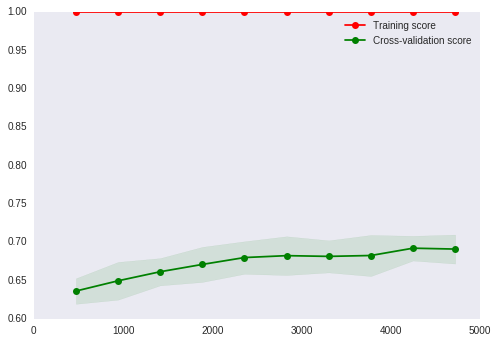

In [62]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators=500), X_train, y_train, train_sizes=np.linspace(.1, 1.0, 10), cv=10)
    
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV


model = RandomForestClassifier()

param_grid = {

"min_samples_leaf": np.arange (1,50),  
"n_estimators": np.arange(10,500)

}

cvmodel = RandomizedSearchCV(model, param_distributions = param_grid, n_iter=100, cv=10)

cvmodel.fit(X_train, y_train)

score = cross_val_score(cvmodel.best_estimator_, X_train, y_train, cv=10)

print np.mean(score), np.std(score)

print(cvmodel.best_estimator_.score(X_test,y_test))

0.684361336308 0.0158715370069
0.690665039658


In [27]:
cvmodel.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=459, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
from sklearn.metrics import recall_score
recall_score(y_test,cvmodel.best_estimator_.predict(X_test))

0.69548872180451127

In [41]:
from sklearn.metrics import precision_score
precision_score(y_test,cvmodel.best_estimator_.predict(X_test))

0.67518248175182483

In [43]:
from sklearn.metrics import f1_score
f1_score(y_test,cvmodel.best_estimator_.predict(X_test))

0.68518518518518523

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,cvmodel.best_estimator_.predict(X_test))

0.68883465527760834

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,cvmodel.best_estimator_.predict(X_test))

array([[580, 261],
       [246, 552]])

ROC AUC: 0.76


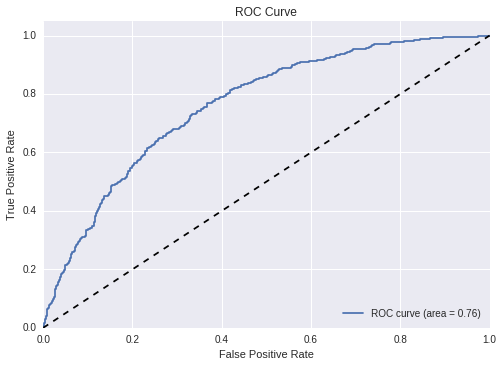

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, cvmodel.best_estimator_.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors","Logistic regression", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=500),
    AdaBoostClassifier(n_estimators=200),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = cross_val_score(clf, X_train, y_train, cv=10)
        testscore=clf.score(X_test,y_test)
        print(name)
        print(np.mean(score))
        print(testscore)

Nearest Neighbors
0.60769262352
0.608297742526
Logistic regression
0.661381005435
0.659548505186
Linear SVM
0.653045183301
0.664429530201
RBF SVM
0.581247057961
0.614399023795
Decision Tree
0.603817143966
0.602806589384
Random Forest
0.684971922006
0.6961561928
AdaBoost
0.656509579938
0.679682733374
Naive Bayes
0.507408126432
0.498474679683
Linear Discriminant Analysis
0.66259885843
0.661989017694
Quadratic Discriminant Analysis
0.493381663032
0.488102501525


In [29]:
model = LogisticRegression(penalty = 'l1')

from sklearn.grid_search import GridSearchCV

param_grid = {

'C': np.logspace(-2, 2, 100)

}

cvmodel = GridSearchCV(model, param_grid, cv=10)

cvmodel.fit(X_train, y_train)

score = cross_val_score(cvmodel.best_estimator_, X_train, y_train, cv=10)

print np.mean(score), np.std(score)

print(cvmodel.best_estimator_.score(X_test,y_test))

0.668178093417 0.0181739921196
0.639481707317


In [30]:
cvmodel.best_estimator_

LogisticRegression(C=0.12328467394420665, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
model = SVC()

scores = cross_val_score(model, X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))  

0.658849449667 0.00689649317828
0.651676829268


In [27]:
from sklearn.cross_validation import cross_val_predict

model = LogisticRegression()

scores = cross_val_score(model, X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test))

0.667429540311 0.0199524831913
0.668445121951


array([[360, 235],
       [200, 517]])

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=20, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test) 

0.62728658536585369

In [31]:
clf.feature_importances_ 

array([  2.47641024e-04,   2.64775554e-04,   2.87788391e-04,
         3.95580232e-04,   2.16818743e-04,   2.69120993e-04,
         1.84416702e-04,   1.97504347e-05,   1.82311182e-05,
         1.35770010e-05,   1.55745437e-06,   0.00000000e+00,
         1.11651812e-04,   2.34741880e-04,   1.44992714e-04,
         2.03628746e-04,   2.66025023e-04,   2.98860144e-04,
         2.20541402e-04,   2.22671700e-04,   1.31252897e-04,
         1.83995599e-04,   1.55173761e-04,   1.74163615e-03,
         2.44754746e-03,   1.65309076e-03,   2.32612725e-03,
         1.64794299e-03,   3.71231909e-03,   3.78542973e-04])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500)

forest.fit(X_train,y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(X_norm_nocat.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)

plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
         color="r", xerr=std[indices], align='center')
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])

In [61]:
X_nocat[0,23:30]

array([  28.,   33.,   10.,   49.,   16.,  295.,   10.])

In [77]:
X.head(1)

,dayofweek,mean_tempf,max_tempf,precipitationIn,mean_dew_pointf,mean_hum,mean_wind_speed,wind_dir_degrees,mean_visibility_miles,cloudcover,mean_sea_level_pressure_in
0,0,28,33,0,10,49,16,295,10,3,29


In [100]:
model = LogisticRegression()

scores = cross_val_score(model, X_train, y_train, cv=10)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.667815462898 0.00673149979877
0.671493902439


In [102]:
from sklearn.svm import LinearSVC
model = LinearSVC()
scores = cross_val_score(model, X_train, y_train, cv=10)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.667815096614 0.00685680834564
0.670731707317


In [33]:
model = LogisticRegression(penalty = 'l1',C = 0.123)

scores = cross_val_score(model, X_train, y_train, cv=10)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.668368569608 0.018266714441
0.639481707317


In [97]:
X.shape[1]

11

In [70]:
model = LogisticRegression(penalty = 'l1')

scores = cross_val_score(model, X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.666287594874 0.00900060209529
0.669969512195


In [72]:
model = LDA()

scores = cross_val_score(model,  X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.66762256311 0.00963328532042
0.584603658537


In [74]:
model = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(model, X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.578182420189 0.00925623849984
0.627286585366


In [75]:
model = RandomForestClassifier(n_estimators = 500)

scores = cross_val_score(model,  X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.677154360023 0.00719523490024
0.692073170732


In [87]:
model = DecisionTreeClassifier()

scores = cross_val_score(model,  X_train, y_train, cv=5)

print np.mean(scores), np.std(scores)

model.fit(X_train, y_train)

print(model.score(X_test,y_test))

0.613460923301 0.00433648548881
0.595274390244


In [243]:
print(datasets.groupby('dayofweek')['count'].count())

dayofweek
0     857
1     888
2     923
3     898
4     890
5    1086
6    1014
Name: count, dtype: int64


<Container object of 7 artists>

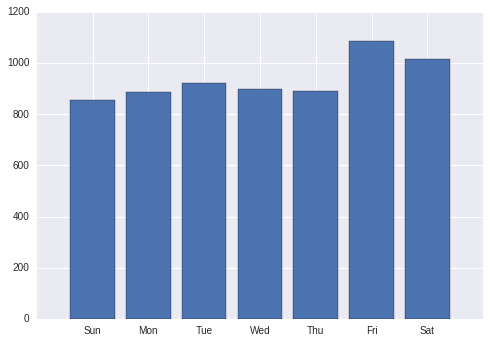

In [148]:
weeday=[0,1,2,3,4,5,6]
plt.bar(weeday,datasets.groupby('dayofweek')['count'].count(),
        tick_label = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],align='center')

In [35]:
print(full.groupby('city')['index_x'].count())

city
Boston, MA      4862
Chicago, IL    57543
DALLAS, TX     24826
Seattle, WA    18116
Name: index_x, dtype: int64


In [ ]:
y.hist()

ERROR! Session/line number was not unique in database. History logging moved to new session 124


In [ ]:
reduced = datasets[datasets['count']]
reduced['count'].hist()

In [105]:
X=reduced[['dayofweek','mean_tempf','max_tempf','precipitationIn', 'mean_dew_pointf','mean_hum','mean_wind_speed','wind_dir_degrees',
'mean_visibility_miles','cloudcover','mean_sea_level_pressure_in']]

y=reduced['count']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=42)

In [38]:
def score_a(model):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print np.mean(scores), np.std(scores)

In [39]:
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
import numpy as np

score_a(Lasso())


0.0339646075874 0.0156515144951


In [40]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
def computing_stat(X, Y):
   lr = LinearRegression()
   lr.fit(X, Y)
   #r^2 of model
#     lr.score(X, Y)
#     # The mean square error
#     print("Residual sum of squares: %.2f"
#           % np.mean((lr.predict(X) - Y) ** 2))
#     # Explained variance score: 1 is perfect prediction
#     print('Variance score: %.2f' % lr.score(X, Y))
   return np.mean((lr.predict(X) - Y) ** 2), lr.score(X, Y)

In [51]:
print(computing_stat(X_train.values,y_train.values))

(7.0803431968633177, 0.057560481518164064)


In [85]:
X_train.values

array([[  8,  35,   2,  37,  15],
       [  2,  92,   6, 102, 164],
       [  2,  34,   1,  42,  92],
       ..., 
       [  8,  52,   3,  57, 150],
       [  5,  64,   3,  75, 105],
       [  1,  74,   6,  87, 211]])

In [70]:
def remove_one_feature(X, Y, names):
   lr = LinearRegression()
   rfe = RFE(lr, n_features_to_select=1)
   rfe.fit(X,Y)
   rank = (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
   print(rank)

In [84]:
total_feature = 10
drop_feature = [] #str type
num_feature = []
r2 = []
rss = []
feature = []
for i in range(total_feature-5):
   array = reduced.values
   Y = array[:,0]
   X = array[:, 1:]
   names = reduced.columns
   rss_temp, r2_temp = computing_stat(X, Y)
#     print("fished stats")
   rss.append(rss_temp)
   r2.append(r2_temp)
   num_feature.append(total_feature-i)
   drop = remove_one_feature(X, Y, names)
#     print("fished remove one "+i)
   drop_feature.append(drop)
   training = reduced.drop(drop, axis=1)
   #print(i)

[(1.0, 'dayofweek'), (2.0, 'cloudcover'), (3.0, 'mean_tempf'), (4.0, 'count'), (5.0, 'max_tempf')]


ValueError: labels [None] not contained in axis

In [79]:
reduced=reduced[['count','cloudcover','mean_tempf','dayofweek','max_tempf','wind_dir_degrees']]

In [83]:
reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4171 entries, 0 to 6550
Data columns (total 6 columns):
count               4171 non-null int64
cloudcover          4171 non-null int64
mean_tempf          4171 non-null int64
dayofweek           4171 non-null int64
max_tempf           4171 non-null int64
wind_dir_degrees    4171 non-null int64
dtypes: int64(6)
memory usage: 228.1 KB


In [81]:
X=reduced[['cloudcover','mean_tempf','dayofweek','max_tempf','wind_dir_degrees']]

y=reduced['count']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.2,random_state=42)

In [82]:
print(computing_stat(X_train.values,y_train.values))

(7.1375241156154869, 0.049949331036218791)


In [80]:
import pickle

pickle.dump(model, open( "model.p", "wb" ) )